In [133]:
import essentia.standard as estd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist, squareform
import statistics as stats
from scipy.signal import find_peaks
import csv
import pandas as pd
import xml.etree.ElementTree as ET


In [179]:
## var init
frame_size = 1024
hop_size = 512
fft_size = 1024

# Dynamic Programming vars
R = 30
C = 30

path_to_data_set = '../mp3/'

#### Get audio vector and inital tempo estimation

In [194]:
path = 'blues-12-8.wav'

def load_audio(path):
    out_fs = 44100
    full_path = path_to_data_set + path
    loader = estd.AudioLoader(filename=full_path)
    downmixer = estd.MonoMixer()
    tempAudioInput, fs, numb_channels, md5, bit_rate, codec = loader()    
    audioInputM = downmixer(tempAudioInput, numb_channels)
    resamp = estd.Resample(inputSampleRate = fs, outputSampleRate = out_fs)
    audioInput = resamp(audioInputM)
    tempo_estimation_algo = estd.PercivalBpmEstimator(sampleRate=int(fs))
    bpm = tempo_estimation_algo(audioInput)
    print(bpm)
    return audioInput, out_fs

#### Compute spectrogram and 2-band energy

In [195]:
# Dynamic Programming Python implementation of Min Cost Path

def minCost(cost, m, n): 
  
    # Instead of following line, we can use int tc[m+1][n+1] or 
    # dynamically allocate memoery to save space. The following 
    # line is used to keep te program simple and make it working 
    # on all compilers.
    tc = [[0 for x in range(C)] for x in range(R)] 
  
    tc[0][0] = cost[0][0] 
  
    # Initialize first column of total cost(tc) array 
    for i in range(1, m+1): 
        tc[i][0] = tc[i-1][0] + cost[i][0] 
  
    # Initialize first row of tc array 
    for j in range(1, n+1): 
        tc[0][j] = tc[0][j-1] + cost[0][j] 
  
    # Construct rest of the tc array 
    for i in range(1, m+1): 
        for j in range(1, n+1): 
            tc[i][j] = min(tc[i-1][j-1], tc[i-1][j], tc[i][j-1]) + cost[i][j] 
  
    return tc[m][n] 

In [196]:
audioInput, fs = load_audio(path)

def compute_spectrogram(audioInput, fs):
    ## get necessary Essentia algorithms
    window_algo = estd.Windowing(normalized=True, size = frame_size, type = 'hann')
    fft_algo = estd.FFT(size = fft_size)

    spectrogram = []
    db_spectrogram = []
    cutoff_bin = int(5000*1024/fs)
    print('Frame Size:', frame_size)
    print('FFT Size:', fft_size)

    for index, frame in enumerate(estd.FrameGenerator(audioInput, frameSize = frame_size, hopSize = hop_size, startFromZero = True)):
        ## spectrogram
        windowed_frame = window_algo(frame)
        mX = abs(fft_algo(windowed_frame))
        mX[mX<np.finfo(float).eps] = np.finfo(float).eps    ## if zeros add epsilon to handle log
        dbX = 20 * np.log10(mX[:cutoff_bin+1])
        spectrogram.append(np.array(mX[:cutoff_bin+1]))
        db_spectrogram.append(np.array(dbX))

    spectrogram = np.array(spectrogram)
    db_spectrogram = np.array(db_spectrogram)
    print('Spectrogram done. Size is (axis1, axis2):', spectrogram.shape)
    return spectrogram, db_spectrogram

119.83695983886719


#### Plot Spectrogram (for visual feedback only)

In [197]:
spectrogram, db_spectrogram = compute_spectrogram(audioInput, fs)

Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2067, 117)


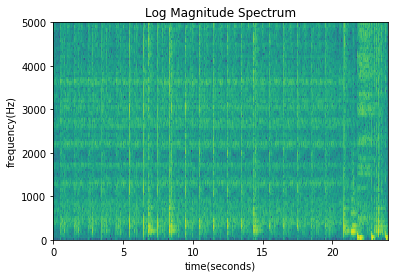

In [198]:
timeAxSec=np.arange(db_spectrogram.shape[0])*hop_size/float(fs)
freqAx_normalized=np.arange(db_spectrogram.shape[1])/float(fft_size)    #Normalized frequency axis
freqAxHz=float(fs)*freqAx_normalized

plt.pcolormesh(timeAxSec,freqAxHz,np.transpose(db_spectrogram))
plt.xlim([0,timeAxSec[-1]])
plt.ylim([0,freqAxHz[-1]])
plt.title('Log Magnitude Spectrum')
plt.ylabel('frequency(Hz)')
plt.xlabel('time(seconds)')
plt.show()

In [199]:

def get_beats_frames(audioInput, fs):
    beatTracker = estd.BeatTrackerDegara()
    beats = beatTracker(audioInput)
    beats_frames = [int(bf) for bf in (beats * fs / hop_size)]
    #print(len(beats))
    return beats_frames

beats_frames = get_beats_frames(audioInput, fs)

In [200]:
def get_ASM(beats_frames, spectrogram):
    beats_neighbour_spect = {}
    i = 0
    while i <= len(beats_frames)-1:
        if i != len(beats_frames)-1:
            beat_duration = beats_frames[i+1] - beats_frames[i]
        duration_8_percent = int(beat_duration*0.08)
        beats_neighbour_spect[beats_frames[i]] = spectrogram[beats_frames[i]-duration_8_percent:beats_frames[i]+duration_8_percent]
        i += 1

    ASM_dict = {}
    for beat_x in beats_neighbour_spect:
        ASM_dict[beat_x] = {}
        for beat_y in beats_neighbour_spect:
            temp_ASM = cdist(beats_neighbour_spect[beat_x], beats_neighbour_spect[beat_y], metric='euclidean')
            ASM_dict[beat_x][beat_y] = temp_ASM
    return ASM_dict

In [201]:
ASM_dict = get_ASM(beats_frames, spectrogram)
print(len(beats_frames))

47


In [202]:
def get_BSM(ASM_dict):
    BSM = []
    counti = 0 
    for beat_frame_i, ASM_beat_dict in ASM_dict.items():
        BSM.append([])
        for beat_frame_j, ASM in ASM_beat_dict.items():
            if ASM.shape == (0,0):
                continue
            BSM[counti].append(minCost(ASM, ASM.shape[0]-1, ASM.shape[1]-1))
        counti += 1
    return BSM


In [203]:
BSM = get_BSM(ASM_dict)

#plt.matshow(BSM[30:90])
#len(BSM)

In [204]:
def get_candidates_list(BSM):
    d = []
    d_inverted = []
    for i, beat in enumerate(BSM):
        d.append(stats.mean(list(np.diagonal(BSM, i))))
        d_inverted.append(-d[i])
    #invert d to have maximums
    d_inverted += max([abs(item) for item in d])
    
    # multiply peaks by 1.5 to accentuate peaks
    d_peaks = find_peaks(d_inverted)[0]
    for i in d_peaks:
        d_inverted[i] *= 1.5
       
    bar_candidates = list(range(2,12))
    lt = math.floor(len(beats)/11)
    tc = []
    for c in bar_candidates:
        t_sum = 0
        for p in range(1, lt+1):
            if p*c >= len(d_inverted):
                continue
            t_sum += (d_inverted[p*c]/(1-((p-1)/lt)))
        tc.append(t_sum)
    return tc



In [205]:
def plot_tc(tc):
    plt.xticks(list(range(10)), bar_candidates)
    plt.plot(tc)
    plt.show()

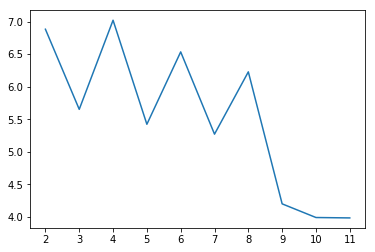

In [206]:
tc = get_candidates_list(BSM)
plot_tc(tc)

In [162]:
def get_top_candidate(tc):
    return tc.index( max(tc) ) + 2 

def get_confidence_top_candidate(tc):
    return max(tc) / sum(tc)

In [163]:
path_to_csv = '../annotations_final.csv'
path_to_xml = '../mp3_echonest_xml'
pd_annotations = pd.read_csv(path_to_csv, '\t')

def getTrackCollection(tag='rock', num=1, minConfidence=0.8):
    collection = {}
    for i in range(pd_annotations.shape[1]):
        if pd_annotations[tag][i] == 1:
            xml_track = ET.parse(path_to_xml + '/' + pd_annotations['mp3_path'][i] + '.xml').getroot()
            for child in xml_track:
                if float(child.attrib['timeSignatureConfidence']) >= minConfidence:
                    if child.attrib['timeSignature'] not in collection:
                        collection[child.attrib['timeSignature']] = []
                    if len(collection[child.attrib['timeSignature']]) < num:
                        if float(child.attrib['timeSignatureConfidence']) >= minConfidence:
                            collection[child.attrib['timeSignature']].append({'path': pd_annotations['mp3_path'][i],
                                                                          'timeSignatureConfidence': child.attrib['timeSignatureConfidence'],
                                                                          'tempo':child.attrib['tempo']})    
    return collection

4
120.0
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


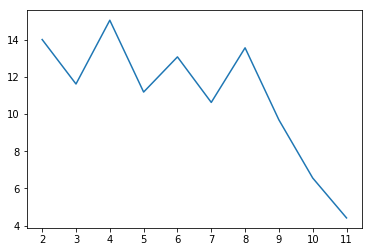

71.42857360839844
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


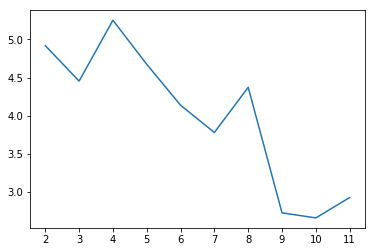

137.61468505859375
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


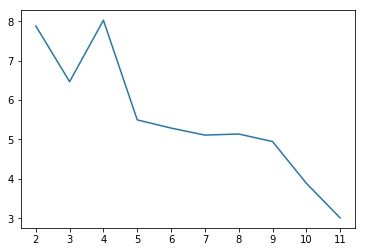

0
7
122.95082092285156
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


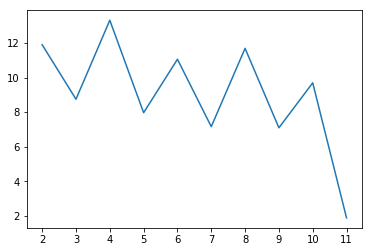

4
94.93670654296875
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


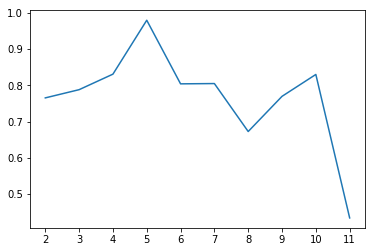

93.75
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


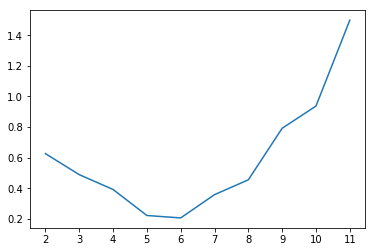

93.75
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


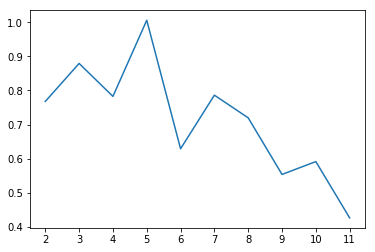

3
92.59259033203125
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


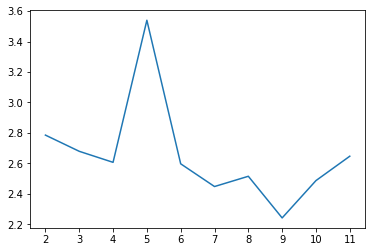

119.04762268066406
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


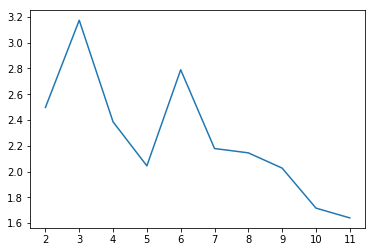

107.14286041259766
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


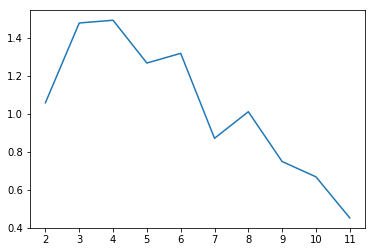

0
7
111.94029998779297
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


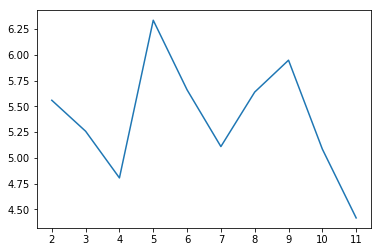

4
105.63380432128906
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


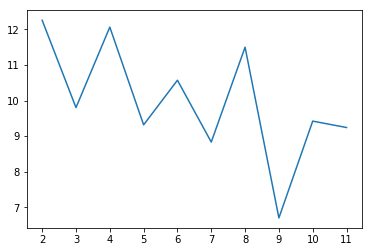

105.63380432128906
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


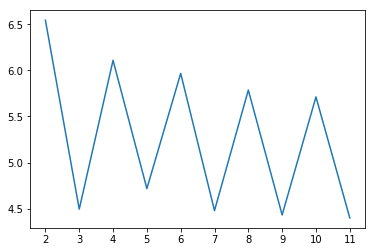

0
4
72.81553649902344
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


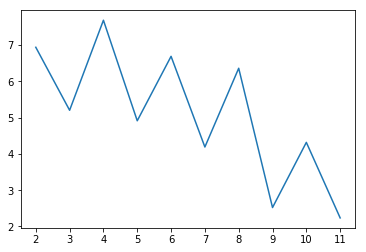

4
94.93670654296875
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


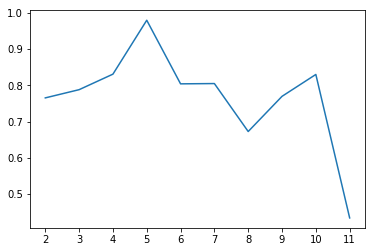

93.75
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


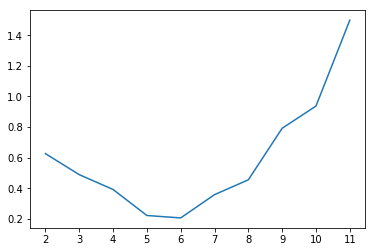

93.75
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


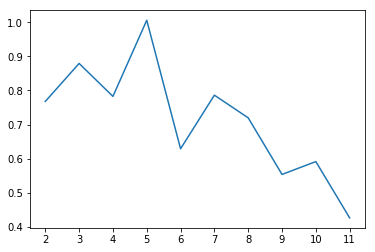

3
129.3103485107422
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


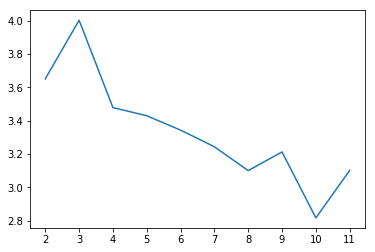

119.04762268066406
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


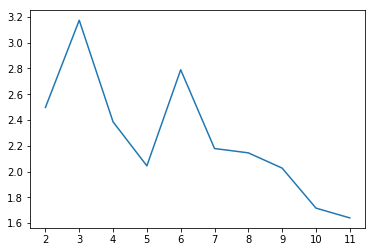

0
4
103.44827270507812
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


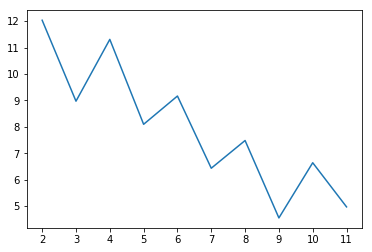

4
72.81553649902344
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


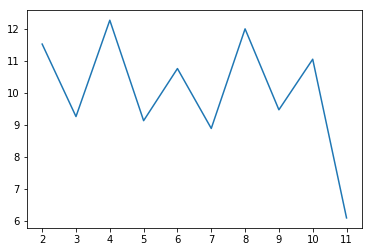

3
96.15384674072266
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


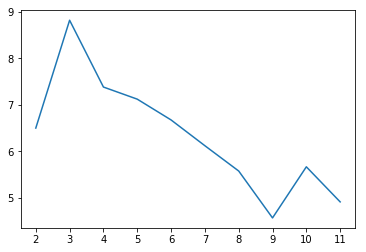

110.29412078857422
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


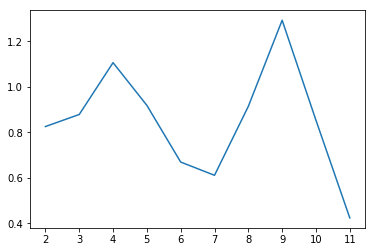

117.1875
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


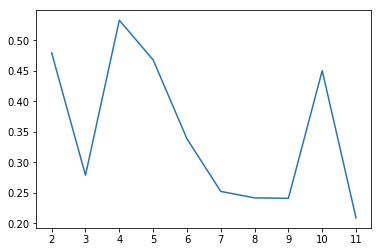

4
137.61468505859375
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


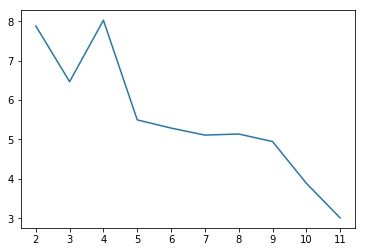

91.46341705322266
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


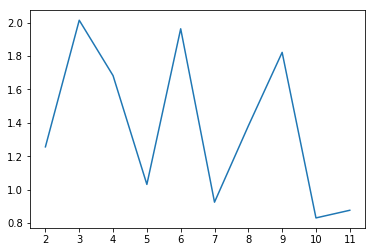

105.63380432128906
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


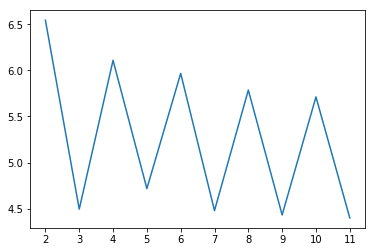

0
7
122.95082092285156
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


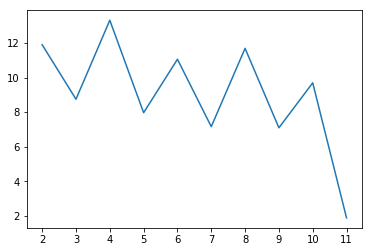

4
120.0
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


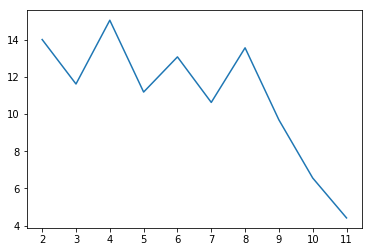

120.0
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


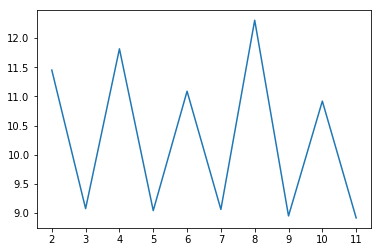

88.23529052734375
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


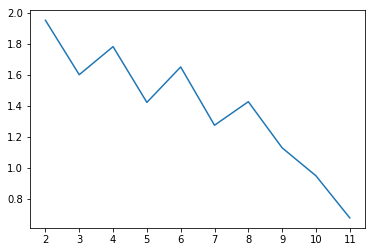

0
3
119.04762268066406
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


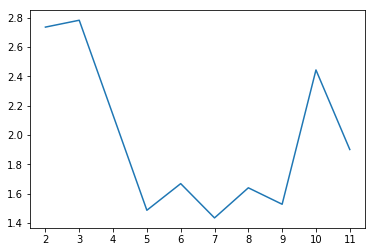

4
117.1875
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


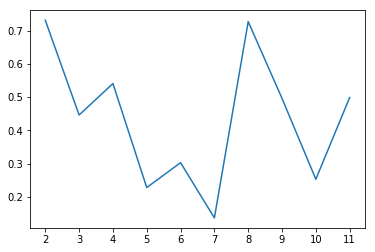

4
86.20689392089844
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


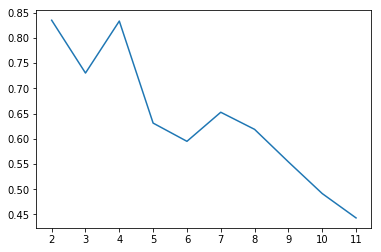

88.23529052734375
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


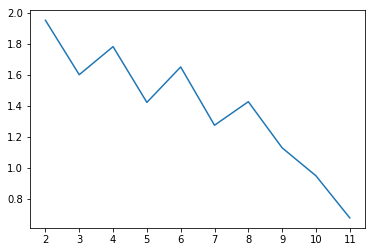

3
83.33333587646484
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


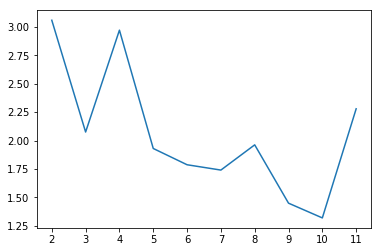

4
91.46341705322266
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


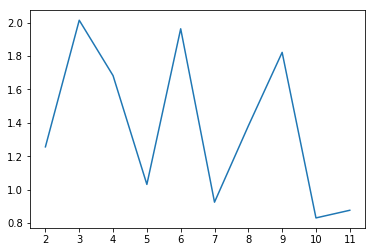

72.81553649902344
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


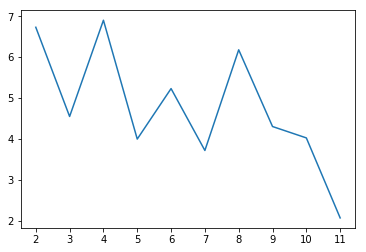

3
117.1875
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


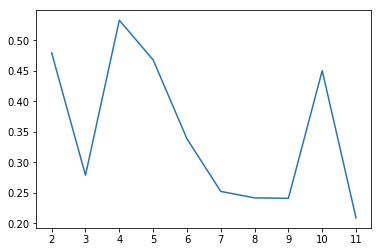

125.0
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


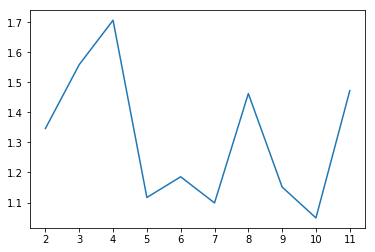

0
0
4
101.35134887695312
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


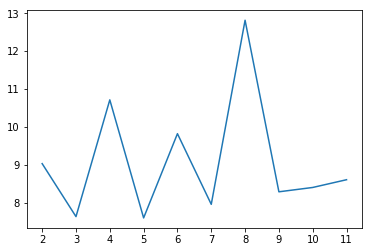

101.35134887695312
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


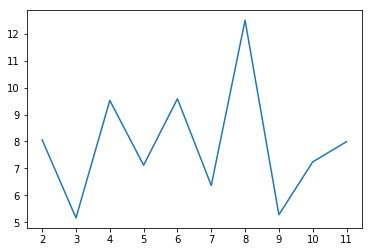

101.35134887695312
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


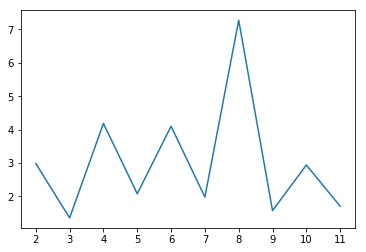

4
120.0
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


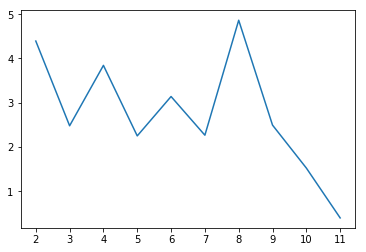

116.27906799316406
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


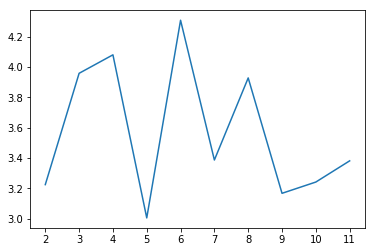

92.59259033203125
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


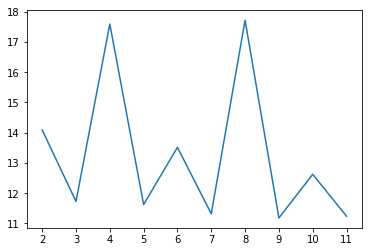

3
102.7397232055664
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


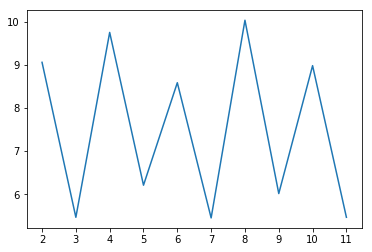

4
72.81553649902344
Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2508, 117)


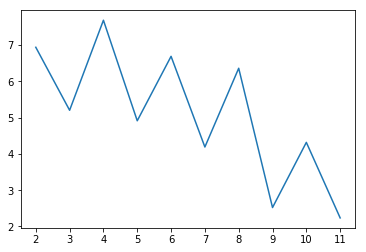

In [167]:
tags = ['rock', 'classical', 'heavy', 'jazz', 'opera','funk', 'funky', 'electronica', 'guitar', 'folk', 'fast', 'irish',
       'arabic', 'instrumental', 'spanish', 'orchestra', 'piano', 'celtic', 'woman', 'dance', 'techno', 'hip hop']
results_dict = {"tag": [], "song":[], "original_ts":[], "conf_original_ts":[], "estimated_ts":[],
                "conf_estimated_ts":[], "equal":[]}


for tag in tags:
    for timeSig, paths in getTrackCollection(tag, 3, 0.8).items():
        print(timeSig)
        if int(timeSig) == 0:
            continue
        for path in paths:
            
            audioInput, fs = load_audio(path['path'])
            spectrogram, db_spectrogram = compute_spectrogram(audioInput, fs)
            beats_frames = get_beats_frames(audioInput, fs)
            ASM_dict = get_ASM(beats_frames, spectrogram)
            BSM = get_BSM(ASM_dict)
            tc = get_candidates_list(BSM)
            plot_tc(tc)
            
            
            top_candidate = get_top_candidate(tc)
            confidence = get_confidence_top_candidate(tc)
            
            results_dict["tag"].append(tag)
            results_dict["song"].append(path['path'])
            results_dict["original_ts"].append(timeSig)
            results_dict["conf_original_ts"].append(path['timeSignatureConfidence'])
            results_dict["estimated_ts"].append(top_candidate)
            results_dict["conf_estimated_ts"].append(confidence)
            results_dict["equal"].append(int(timeSig) == int(top_candidate))

In [168]:
df_results = pd.DataFrame(results_dict)
print(df_results)

          tag                                               song original_ts  \
0        rock       c/lvx_nova-lvx_nova-01-contimune-233-262.mp3           4   
1        rock  0/rocket_city_riot-last_of_the_pleasure_seeker...           4   
2        rock  0/rocket_city_riot-last_of_the_pleasure_seeker...           4   
3        rock  c/mountain_mirrors-lunar_ecstasy-01-a_short_bu...           7   
4   classical  f/american_bach_soloists-j_s__bach_solo_cantat...           4   
5   classical  f/american_bach_soloists-j_s__bach_solo_cantat...           4   
6   classical  f/american_bach_soloists-j_s__bach_solo_cantat...           4   
7   classical  0/american_bach_soloists-j_s__bach__cantatas_v...           3   
8   classical  9/american_bach_soloists-heinrich_schutz__musi...           3   
9   classical  9/american_bach_soloists-heinrich_schutz__musi...           3   
10  classical  5/new_york_consort_of_viols-dances_and_canzona...           7   
11      heavy     f/pain_factor-8_second

In [174]:

print(sum(df_results['equal']==True) / len(df_results['equal']))


0.2916666666666667


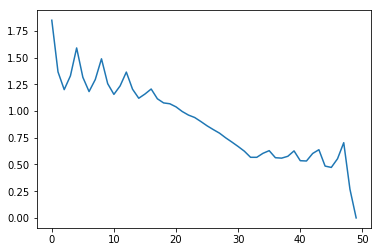

In [23]:
plt.plot(d_inverted)

In [24]:
d_peaks = find_peaks(d_inverted)[0]
for i in d_peaks:
    d_inverted[i] *= 2

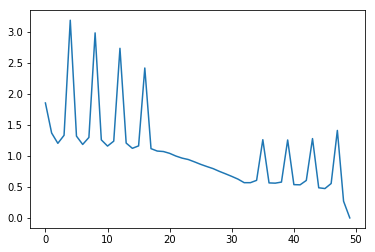

In [25]:
plt.plot(d_inverted)

In [26]:
d_inverted

array([1.84986826, 1.36666542, 1.20054926, 1.32975245, 3.18135514,
       1.31623918, 1.18240345, 1.2949346 , 2.97787717, 1.25620335,
       1.15615234, 1.23551906, 2.72943351, 1.20452763, 1.11989831,
       1.1593935 , 2.41260231, 1.11483459, 1.07619973, 1.06835565,
       1.03918446, 0.99581951, 0.96248221, 0.93983959, 0.90200979,
       0.86189709, 0.82661726, 0.79322338, 0.74927104, 0.70963652,
       0.66844164, 0.62448622, 0.56725583, 0.56711566, 0.60460611,
       1.25881232, 0.56340398, 0.55942374, 0.576711  , 1.2543574 ,
       0.53557839, 0.53261714, 0.60305261, 1.27672997, 0.48500053,
       0.47256516, 0.55366153, 1.40794441, 0.26865423, 0.        ])

In [27]:
bar_candidates = list(range(2,12))
lt = math.floor(len(beats)/11)
tc = []
for c in bar_candidates:
    t_sum = 0
    for p in range(1, lt+1):
        t_sum += (d_inverted[p*c]/(1-((p-1)/lt)))
    tc.append(t_sum)

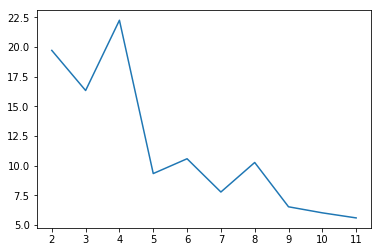

In [28]:
plt.xticks(list(range(10)), bar_candidates)
plt.plot(tc)